In [ ]:
import pycrfsuite

In [ ]:
from collections import Counter
import numpy as np
%pylab inline

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
from _chain import Chain
from _pytorch_chain_loss import belief_propagation_cross_entropy_loss

### Define Binary HMM 

In [ ]:
def f_phi(x1, x2):
#     p = np.array([
#     [0.58, 0.42],
#     [0.42, 0.58]])
#     return p[x1, x2]
    b = [-0.32, 0.4]
    return exp(b[x1] * (x2 - 0.5))

In [ ]:
def f_psi(x1, x2):
#     p = np.array([
#     [0.62, 0.38],
#     [0.34, 0.66]])
#     return p[x1, x2]
    j = np.array([
    [-1.91, 3.8],
    [4.31, -1.66]])
    return exp(j[x1, x2] * (x1 - 0.5) * (x2 - 0.5))

In [ ]:
phi = f_phi
psi = f_psi

In [ ]:
T = 50 # chain length

In [415]:
chain = Chain(length=T, phi=phi, psi=psi, possible_values=[0, 1])

### Create Random Trainset

In [416]:
possible_values = [0, 1]

In [417]:
N = 10000

In [418]:
%%time 

X_dataset = []
y_dataset= []

for i in range(N):
    x = np.random.rand(T)
    x_binary = 1 * (x > 0.5)
    
    chain.update_observed(x_binary)
    y = chain.get_max_apostriori_beliefs()

    X_dataset.append(x_binary)
    y_dataset.append(y)

CPU times: user 39.2 s, sys: 231 ms, total: 39.5 s
Wall time: 39.5 s


In [419]:
# turn to numpy arrays
X_dataset = np.array([np.array(xi) for xi in X_dataset])
y_dataset = np.array([np.array(yi) for yi in y_dataset])

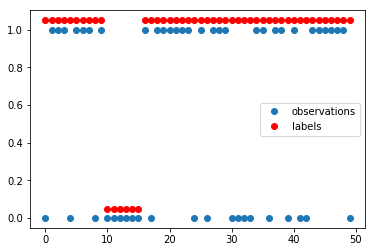

In [435]:
plot(X_dataset[0], 'o')
plot(y_dataset[0] + 0.05, 'ro')
legend(['observations', 'labels'])

### Train Dummy Model (predicts y = x)

#### Train-Test split

In [421]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

#### Evaluate 

In [422]:
y_pred = X_test

In [423]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.42      0.82      0.56     25725
           1       0.91      0.61      0.73     74275

   micro avg       0.67      0.67      0.67    100000
   macro avg       0.67      0.72      0.65    100000
weighted avg       0.78      0.67      0.69    100000



### Train CRF

In [424]:
def extract_features(x):
    features = [
        'x.current=' + str(x)
    ]
    return features

In [425]:
def extract_labels(y):
    return str(y)

#### Preprocess Dataset

In [426]:
X = []
y = []

for xseq, yseq in zip(X_dataset, y_dataset):
    X_features = [extract_features(x_i) for x_i in xseq]
    y_labels = [extract_labels(y_i) for y_i in yseq]
    
    X.append(X_features)
    y.append(y_labels)

#### Train-Test split 

In [427]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

#### Train 

In [428]:
import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

In [429]:
%%time
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0,
    c2=1,
    max_iterations=1000,
    all_possible_transitions=True,
    all_possible_states=True
)
crf.fit(X_train, y_train)

CPU times: user 2.55 s, sys: 8.17 ms, total: 2.55 s
Wall time: 2.56 s


In [430]:
y_pred = crf.predict(X_test)

In [431]:
labels = list(crf.classes_)
labels

['0', '1']

In [432]:
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_test, y_pred, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           0      0.996     0.963     0.979     26488
           1      0.987     0.999     0.993     73512

   micro avg      0.989     0.989     0.989    100000
   macro avg      0.991     0.981     0.986    100000
weighted avg      0.989     0.989     0.989    100000



In [433]:
def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

Transitions:
0      -> 0       10.113959
1      -> 1       8.934612
1      -> 0       -9.478499
0      -> 1       -9.570072


In [434]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("States:")
print_state_features(Counter(crf.state_features_).most_common(30))

States:
7.612727 1        x.current=1
3.979545 0        x.current=0
-3.979545 1        x.current=0
-7.612727 0        x.current=1


### Training FC NN 

#### Define 

In [240]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

In [241]:
n_epochs = 200
batch_size, D_in, D_hidden, D_out = 256, T, T, T

In [242]:
model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Sigmoid()
        )

optimizer = optim.Adam(model.parameters(), lr=0.01)

In [243]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [244]:
print('Network has {} parameters, notice your training set size!'.format(count_parameters(model)))

Network has 15300 parameters, notice your training set size!


In [245]:
from torch.utils.data import Dataset

class ChainDataset(Dataset):
    
    def __init__(self, X, y, flatten=True):
        self._X = X
        self._y = y

    def __len__(self):
        return len(self._X)

    def __getitem__(self, idx):
        sample = {
            'X': torch.from_numpy(self._X[idx]).float(),
            'y': torch.from_numpy(self._y[idx]).float()  
        }
        return sample

In [246]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, test_size=0.2)

In [247]:
trainset = ChainDataset(X_train, y_train)
testset = ChainDataset(X_test, y_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=True, num_workers=2)

#### Train 

In [248]:
model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        model.zero_grad()
        
        y_pred = model(X_batch)
        loss = F.binary_cross_entropy(y_pred, y_batch)
        
        loss.backward()
        optimizer.step()
    
    if epoch % 10 == 0:
        valid = next(iter(validloader))
        X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
        y_pred_valid = model(X_valid)
        loss_valid = F.binary_cross_entropy(y_pred_valid, y_valid)
        
        print('epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
        learning_curve.append((loss, loss_valid))

epoch 10:: loss = 0.29856806993484497, validation loss = 0.32029205560684204
epoch 20:: loss = 0.2794925272464752, validation loss = 0.23905697464942932
epoch 30:: loss = 0.18758605420589447, validation loss = 0.22915531694889069
epoch 40:: loss = 0.17564928531646729, validation loss = 0.19146676361560822
epoch 50:: loss = 0.16913072764873505, validation loss = 0.18398338556289673
epoch 60:: loss = 0.1619027704000473, validation loss = 0.18534769117832184
epoch 70:: loss = 0.13493146002292633, validation loss = 0.18738247454166412
epoch 80:: loss = 0.13348641991615295, validation loss = 0.18346308171749115
epoch 90:: loss = 0.15320050716400146, validation loss = 0.18187324702739716
epoch 100:: loss = 0.10409501194953918, validation loss = 0.18497931957244873
epoch 110:: loss = 0.11753132939338684, validation loss = 0.19185620546340942
epoch 120:: loss = 0.10388041287660599, validation loss = 0.1901145577430725
epoch 130:: loss = 0.11956211179494858, validation loss = 0.1843060702085495

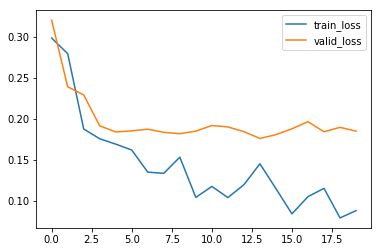

In [249]:
plot([tr_loss for tr_loss, valid_loss in learning_curve]);
plot([valid_loss for tr_loss, valid_loss in learning_curve]);
legend(['train_loss', 'valid_loss'])

#### Evaluate 

In [250]:
model.eval()

Sequential(
  (0): Linear(in_features=50, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=50, bias=True)
  (5): ReLU()
  (6): Linear(in_features=50, out_features=50, bias=True)
  (7): ReLU()
  (8): Linear(in_features=50, out_features=50, bias=True)
  (9): ReLU()
  (10): Linear(in_features=50, out_features=50, bias=True)
  (11): Sigmoid()
)

In [251]:
y_pred = np.array([model(torch.from_numpy(xseq).float()).detach().numpy() for xseq in X_test])

In [252]:
y_pred = 1 * (y_pred > 0.5)

In [253]:
labels = {0 : 0, 1: 1}

predictions = np.array([labels[tag] for row in y_pred for tag in row])
truths = np.array([labels[tag] for row in y_test for tag in row])

print(classification_report(
    truths, predictions,
    target_names=["0", "1"]))

              precision    recall  f1-score   support

           0       0.86      0.83      0.85     23777
           1       0.95      0.96      0.95     76223

   micro avg       0.93      0.93      0.93    100000
   macro avg       0.91      0.90      0.90    100000
weighted avg       0.93      0.93      0.93    100000



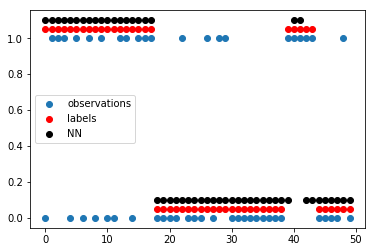

In [255]:
i = np.random.randint(200)
plot(X_test[i], 'o')
plot(y_test[i] + 0.05, 'ro')
plot(y_pred[i] + 0.1, 'ko')
legend(['observations', 'labels', 'NN'])

###  Training MPNN based model

In [287]:
n_epochs = 5
batch_size, D_in, D_hidden = 256, T, T
D_out = 2 * T - 1  # J is of size T-1 on chain and b is of size T

In [288]:
energy_model = torch.nn.Sequential(
          torch.nn.Linear(D_in, D_hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(D_hidden, D_out),
          torch.nn.Tanh()
        )

optimizer = optim.Adam(energy_model.parameters(), lr=0.01)

In [302]:
energy_model.train()
learning_curve = []

for epoch in range(1, n_epochs + 1):
    
    for batch in trainloader:
        
        X_batch, y_batch = Variable(batch['X']), Variable(batch['y'])
        energy_model.zero_grad()
        
        energy = energy_model(X_batch)
        j, b = energy[:, 0:T-1], energy[:, T-1:]

        loss = belief_propagation_cross_entropy_loss(j, b, y_batch)
        
        loss.backward()
        optimizer.step()

        if epoch % 1 == 0:
            valid = next(iter(validloader))
            X_valid, y_valid = Variable(valid['X']), Variable(valid['y']) 
            energy_valid = energy_model(X_valid)
            j_valid, b_valid = energy_valid[:, 0:T-1], energy_valid[:, T-1:]
            loss_valid = belief_propagation_cross_entropy_loss(j_valid, b_valid, y_valid)

            print('epoch {}:: loss = {}, validation loss = {}'. format(epoch, loss, loss_valid))
            learning_curve.append((loss, loss_valid))

epoch 1:: loss = 4374.22412109375, validation loss = 33994.3203125
epoch 1:: loss = 4344.85498046875, validation loss = 33993.0234375
epoch 1:: loss = 4361.7294921875, validation loss = 34009.64453125
epoch 1:: loss = 4255.28369140625, validation loss = 33999.16015625
epoch 1:: loss = 4327.970703125, validation loss = 34001.50390625
epoch 1:: loss = 4318.9775390625, validation loss = 34003.6640625
epoch 1:: loss = 4361.515625, validation loss = 34000.31640625


KeyboardInterrupt: 

In [300]:
def belief_propagation_cross_entropy_loss(j, b, labels):
    batch_size = labels.size()[0]
    len_ = b[0].size().numel() # length of chain
    
    loss = 0
    
    for b_idx in range(batch_size):

        values = torch.Tensor([0, 1]) - 0.5
        pairs = torch.mul(values.view(-1, 2).t(), values)
        unit_msg = torch.ones((2, 1))

        forward_messages = unit_msg
        msg_left = unit_msg # no information traveling left to x1
        # forward pass    
        for i in range(0, len_ - 1):

            phi = torch.exp(torch.mul(b[b_idx][i], values))
            psi = torch.exp(torch.mul(j[b_idx][i], pairs))
            step1 = torch.mul(psi, msg_left)
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            forward_messages = torch.cat((forward_messages, msg), dim=1)    
            msg_left = msg

        backward_messages = unit_msg
        msg_right = unit_msg # no information traveling right to x_n
        # backward pass    
        for i in range(len_ - 1, 0, -1):

            phi = torch.exp(torch.mul(b[b_idx][i], values))
            psi = torch.exp(torch.mul(j[b_idx][i - 1], pairs))
            step1 = torch.mul(psi, msg_right)
            step2 = torch.mul(step1, psi)
            step3, _ = torch.max(step2, dim=1)

            msg = step3.view(-1 ,1)
            backward_messages = torch.cat((backward_messages, msg), dim=1)    
            msg_right = msg

        # calculate beliefs
        messages = torch.mul(forward_messages, backward_messages)
        data_term = torch.exp(torch.mul(b[b_idx], values.view(-1, 1)))
        beliefs = torch.mul(data_term, messages)
        beliefs_norm = torch.softmax(beliefs, dim=0)

        loss += F.binary_cross_entropy(beliefs_norm[1, :], labels[b_idx])
    return loss

In [303]:
X_dataset[0]

array([1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1])